In [1]:
import warnings;
warnings.simplefilter('ignore')

In [2]:
#!pip install prophet

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import numpy as np
from neuralprophet import NeuralProphet


In [4]:
data = pd.read_csv('crime-per-county.csv')

In [5]:
data.head()


,STATISTIC Label,Quarter,Garda Division,Type of Offence,UNIT,VALUE
0,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Homicide offences,Number,1.0
1,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Murder,Number,0.0
2,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Manslaughter,Number,0.0
3,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Infanticide,Number,0.0
4,Recorded crime incidents,2003Q1,Cavan/Monaghan Garda Division,Dangerous driving leading to death,Number,1.0


In [6]:
data.drop(columns =["STATISTIC Label", "UNIT"], inplace=True)

In [7]:
data['VALUE'] = data['VALUE'].fillna(0)
data['VALUE'] = data['VALUE'].astype('int64')

In [8]:
def quarter_to_date(year_quarter):
    year, quarter = year_quarter.split('Q')
    first_month = {'1': '01', '2' : '04' , '3' : '07' , '4' : '10'}
    return f"{year}-{first_month[quarter]}-1"

data['Date'] = data['Quarter'].apply(quarter_to_date)


In [9]:
# Correct way using .loc to avoid SettingWithCopyWarning
data.loc[:, 'Date'] = pd.to_datetime(data['Date'])



In [10]:
data['Date'] = pd.to_datetime(data['Date'])

In [11]:
#data.set_index('Date', inplace=True)

In [12]:
data.drop(columns =['Quarter'], inplace=True)

In [13]:
data = data[data['VALUE'] != 0]

In [14]:
data.info() 
data.describe()

<class 'pandas.core.frame.DataFrame'>
Index: 120808 entries, 0 to 166991
Data columns (total 4 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   Garda Division   120808 non-null  object        
 1   Type of Offence  120808 non-null  object        
 2   VALUE            120808 non-null  int64         
 3   Date             120808 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 4.6+ MB


,VALUE,Date
count,120808.000000,120808
mean,81.256763,2013-06-16 19:43:56.408185088
min,1.000000,2003-01-01 00:00:00
25%,2.000000,2008-04-01 00:00:00
50%,16.000000,2013-07-01 00:00:00
75%,86.000000,2018-10-01 00:00:00
max,2541.000000,2023-10-01 00:00:00
std,170.400775,NaN


In [15]:
# Filter the data for "Theft from person" crimes in "D.M.R. North Central Garda Division"
theft_from_person_data = data[
    (data['Type of Offence'] == 'Theft from person') & 
    (data['Garda Division'] == 'D.M.R. North Central Garda Division')
]

In [16]:
theft_from_person_data.drop(columns =['Garda Division', 'Type of Offence'], inplace=True)

In [17]:
theft_from_person_data.head()

,VALUE,Date
1672,289,2003-01-01
3660,310,2003-04-01
5648,242,2003-07-01
7636,272,2003-10-01
9624,239,2004-01-01


In [18]:
theft_from_person_data.columns =['y', 'ds']

In [19]:
theft_from_person_data.head()

,y,ds
1672,289,2003-01-01
3660,310,2003-04-01
5648,242,2003-07-01
7636,272,2003-10-01
9624,239,2004-01-01


In [20]:
# Extracting only the year from the 'ds' column
#data['ds'] = data['ds'].dt.year

In [21]:
m = NeuralProphet()
m.fit(theft_from_person_data, freq = 'Q', epochs = 1000)

WARNING - (NP.forecaster.fit) - When Global modeling with local normalization, metrics are displayed in normalized scale.
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 79.762% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - QS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 8
WARNING - (NP.config.set_lr_finder_args) - Learning rate finder: The number of batches (11) is too small than the required number                     for the learning rate finder (206). The results might not be optimal.


Finding best initial lr:   0%|          | 0/206 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

,MAE,RMSE,Loss,RegLoss,epoch
0,178.670593,224.994370,0.314276,0.0,0
1,172.528671,217.367569,0.307203,0.0,1
2,156.867844,195.177383,0.267503,0.0,2
3,144.808578,178.556000,0.242185,0.0,3
4,136.168991,167.702530,0.221945,0.0,4
...,...,...,...,...,...
995,43.266487,53.353588,0.037024,0.0,995
996,44.007816,53.928196,0.038672,0.0,996
997,44.206917,53.249741,0.037857,0.0,997
998,44.909634,54.952175,0.039456,0.0,998


In [22]:
future = m.make_future_dataframe(theft_from_person_data, periods=10)
forecast = m.predict(future)
forecast.head(20)

INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 79.762% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - QS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 70.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - QS
INFO - (NP.df_utils._infer_frequency) - Major frequency QS corresponds to 70.0% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - QS


Predicting: 11it [00:00, ?it/s]

INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


,ds,y,yhat1,trend,season_yearly
0,2024-01-01,None,192.634460,140.762085,51.872387
1,2024-04-01,None,100.797455,135.160461,-34.362995
2,2024-07-01,None,107.923874,129.558868,-21.634991
3,2024-10-01,None,110.371010,123.895607,-13.524600
4,2025-01-01,None,109.010941,118.232468,-9.221523
5,2025-04-01,None,111.618347,112.692398,-1.074048
6,2025-07-01,None,110.189682,107.090775,3.098907
7,2025-10-01,None,118.502419,101.427597,17.074823
8,2026-01-01,None,106.944183,95.764412,11.179770
9,2026-04-01,None,122.217834,90.224388,31.993454


In [23]:
plot = m.plot(forecast)

# Prophet

In [24]:
from prophet import Prophet

In [25]:
theft_from_person_data.describe()

,y,ds
count,84.000000,84
mean,248.202381,2013-05-16 19:08:34.285714176
min,77.000000,2003-01-01 00:00:00
25%,157.000000,2008-03-09 06:00:00
50%,245.000000,2013-05-16 12:00:00
75%,327.000000,2018-07-24 00:00:00
max,470.000000,2023-10-01 00:00:00
std,102.827939,NaN


In [26]:
m_prophet = Prophet(interval_width=0.95)
model_prophet = m_prophet.fit(theft_from_person_data)

16:02:06 - cmdstanpy - INFO - Chain [1] start processing
16:02:06 - cmdstanpy - INFO - Chain [1] done processing


In [33]:
future_prophet = m_prophet.make_future_dataframe(periods=8, freq = 'Q')
forecast_prophet = m_prophet.predict(future_prophet)
forecast_prophet.tail(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
82,2023-07-01,367.047763,112.586490,506.317579,367.047763,367.047763,-59.097250,-59.097250,-59.097250,-59.097250,-59.097250,-59.097250,0.0,0.0,0.0,307.950512
83,2023-10-01,368.226300,147.429039,517.372730,368.226300,368.226300,-41.034973,-41.034973,-41.034973,-41.034973,-41.034973,-41.034973,0.0,0.0,0.0,327.191327
84,2023-12-31,369.392027,256.735510,613.351234,369.391603,369.392389,55.579531,55.579531,55.579531,55.579531,55.579531,55.579531,0.0,0.0,0.0,424.971558
85,2024-03-31,370.557754,142.113843,514.984567,370.556463,370.558774,-44.297856,-44.297856,-44.297856,-44.297856,-44.297856,-44.297856,0.0,0.0,0.0,326.259898
86,2024-06-30,371.723481,131.948039,513.155602,371.721015,371.725425,-45.477844,-45.477844,-45.477844,-45.477844,-45.477844,-45.477844,0.0,0.0,0.0,326.245637
87,2024-09-30,372.902019,165.638953,544.407823,372.898230,372.904926,-23.722431,-23.722431,-23.722431,-23.722431,-23.722431,-23.722431,0.0,0.0,0.0,349.179588
88,2024-12-31,374.080556,174.006868,539.787069,374.075445,374.084742,-13.970361,-13.970361,-13.970361,-13.970361,-13.970361,-13.970361,0.0,0.0,0.0,360.110195
89,2025-03-31,375.233473,164.892573,523.309580,375.227056,375.238716,-30.489706,-30.489706,-30.489706,-30.489706,-30.489706,-30.489706,0.0,0.0,0.0,344.743767
90,2025-06-30,376.399200,169.564610,535.266415,376.391396,376.405884,-30.456916,-30.456916,-30.456916,-30.456916,-30.456916,-30.456916,0.0,0.0,0.0,345.942284
91,2025-09-30,377.577738,172.460249,550.687335,377.568559,377.585718,-6.349194,-6.349194,-6.349194,-6.349194,-6.349194,-6.349194,0.0,0.0,0.0,371.228544


In [38]:
forecast_prophet[['ds', 'yhat']].tail(7)


,ds,yhat
85,2024-03-31,326.259898
86,2024-06-30,326.245637
87,2024-09-30,349.179588
88,2024-12-31,360.110195
89,2025-03-31,344.743767
90,2025-06-30,345.942284
91,2025-09-30,371.228544


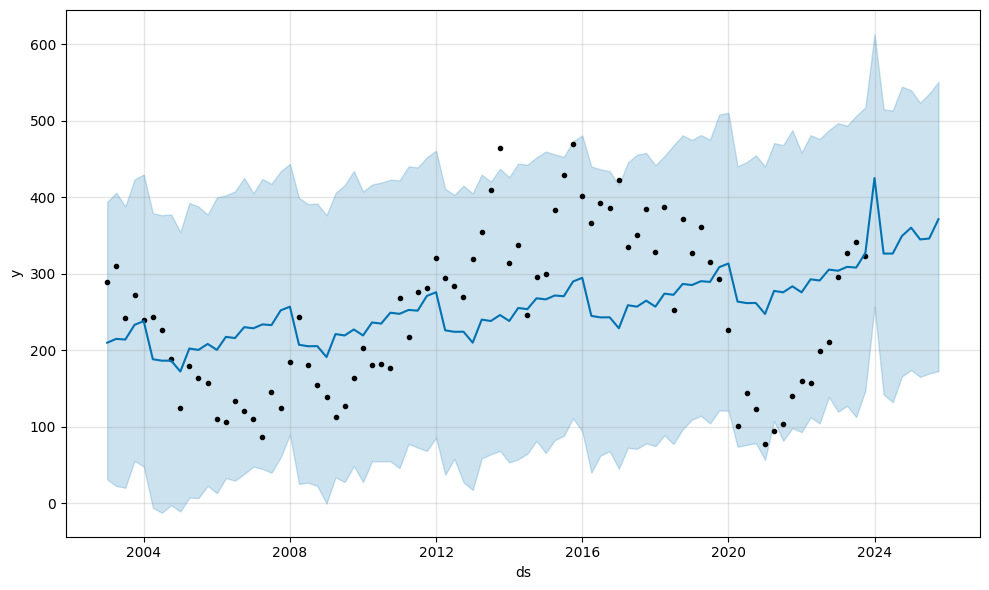

In [35]:
plot1 = m_prophet.plot(forecast_prophet)

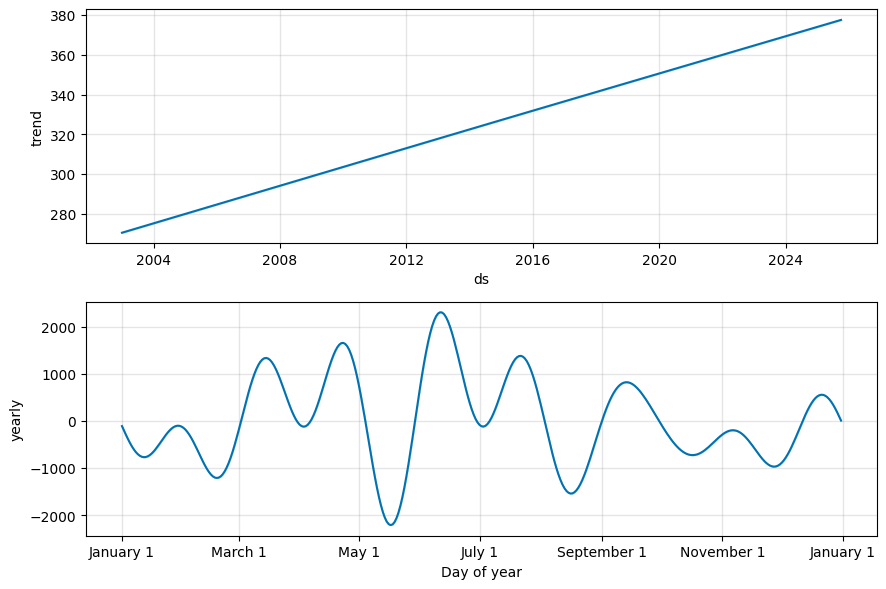

In [36]:
plot2 = m_prophet.plot_components(forecast_prophet)